## 讀書會2 蜘蛛人電影分析

## 大綱

1. 套件和資料載入
2. CKIP 文字處理
3. NER 和 POS 分析
4. SNOWNLP 分析

### 目標
了解大眾對於漫威電影宇宙的蜘蛛人的評價。

# 1. 套件和資料載入

In [2]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import configparser, re, os, io

from wordcloud import WordCloud, ImageColorGenerator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/tensorflow/python/frame

In [2]:
#data_utils.download_data_gdown("https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771&export=download")

In [3]:
# Setting GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Load model & Setting GPU
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

## 資料載入

In [15]:
import sys
import csv

csv.field_size_limit(sys.maxsize)

131072

In [16]:
#蜘蛛人文章
df = pd.read_csv('./raw_data/spiderman.csv')
df.dtypes

system_id        int64
artUrl          object
artTitle        object
artDate         object
artPoster       object
artCatagory     object
artContent      object
artComment      object
e_ip            object
insertedDate    object
dataSource      object
dtype: object

In [17]:
df = df[df['artContent'].notnull()]

定義文字清理的相關function

In [10]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    final_res = []
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    
#     paragraphs = list(filter(None, article.split("\n")))
    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
#     print(len(paragraphs))
#     print(paragraphs)
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            _logger.info("error")
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

(2) CKIP 處理相關function

In [11]:
# 自定義辭典
with open('dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(2, {'蟻人': 500.0, '黑豹': 500.0, '趙婷': 500.0}), (3, {'鋼鐵人': 500.0, '蜘蛛人': 500.0, '離家日': 500.0, '黑寡婦': 500.0, '永恆族': 500.0, '無家日': 500.0}), (4, {'無敵浩克': 500.0, '雷神索爾': 500.0, '美國隊長': 500.0, '黑暗世界': 500.0, '酷寒戰士': 500.0, '奧創紀元': 500.0, '英雄內戰': 500.0, '奇異博士': 500.0, '無限之戰': 500.0, '驚奇隊長': 500.0, '終局之戰': 500.0, '第四階段': 500.0, '愛與雷霆': 500.0, '蜘蛛人2': 500.0, '蜘蛛人3': 500.0}), (5, {'復仇者聯盟': 500.0, '星際異攻隊': 500.0, '派屈克布雷': 500.0, '萊恩菲爾波': 500.0, '馬修菲爾波': 500.0, '瓦干達萬歲': 500.0}), (6, {'蟻人與黃蜂女': 500.0, '多元宇宙傳奇': 500.0, '失控多重宇宙': 500.0, '蜘蛛人返校日': 500.0, '蜘蛛人離家日': 500.0, '蜘蛛人無家日': 500.0}), (7, {'尚氣與十環傳奇': 500.0, '蜘蛛人驚奇再起': 500.0, '蜘蛛人：返校日': 500.0, '蜘蛛人：離家日': 500.0, '蜘蛛人：無家日': 500.0}), (8, {'蜘蛛人：驚奇再起': 500.0}), (10, {'漫威電影宇宙第四階段': 500.0}), (12, {'蜘蛛人驚奇再起2電光之戰': 500.0}), (13, {'蜘蛛人驚奇再起2：電光之戰': 500.0})]


In [12]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
#     print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id,word,pos]) 
#         print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
#     print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3],entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    for index, row in data_df.iterrows(): # document level    
#         print(f"\ndocument {index}") 

        # clean data
        result = [] 
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary=dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        for i, sentence in enumerate(flat_list): # sentence level
#             print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'],sentence])            
            temp_tokens = get_pos(row['system_id'],word_sentence_list[i],  pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'],entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [13]:
# 看看tmp和flat_list有什麼差別
tmp = Sentence_Segmentation(df['artContent'][0]) 
flat_list = [item for sublist in tmp for item in sublist]
print(tmp[:5])
print(flat_list[:5])

[['完整圖文版'], ['///'], ['號稱強片年，好萊塢的大片波接波，票房紀錄個個破，但品質卻不見得個'], ['比個好', '尤其續集電影們雖然吊足了大家的胃口，但劇情的了無新意和預料中的發展，'], ['帶來的滿足感還是遠不及原創電影', '甚至今年年初有度覺得心情低落，因為直沒看到']]
['完整圖文版', '///', '號稱強片年，好萊塢的大片波接波，票房紀錄個個破，但品質卻不見得個', '比個好', '尤其續集電影們雖然吊足了大家的胃口，但劇情的了無新意和預料中的發展，']


In [14]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 2122.2654559612274


In [15]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") 
print(f"posts have NER: {len(entity_table['system_id'].unique())}") 

total posts numbers: 5399
posts have NER: 5211


In [17]:
# 將文章存成csv
pos_table.to_csv('raw_data/pos_table_spiderman.csv', index = False)
entity_table.to_csv('raw_data/entity_spiderman.csv', index = False)
sentence_table.to_csv('raw_data/sentence_spiderman.csv', index = False)

### 3 探索分析 - NER

In [18]:
# 讀取已經執行完畢的結果
pos_table = pd.read_csv("raw_data/pos_table_spiderman.csv") 
entity_table = pd.read_csv("raw_data/entity_spiderman.csv") 
sentence_table = pd.read_csv("raw_data/sentence_spiderman.csv") 

In [19]:
entity_table['ner'].unique()

array(['ORG', 'DATE', 'CARDINAL', 'ORDINAL', 'PERSON', 'NORP', 'GPE',
       'TIME', 'LOC', 'MONEY', 'EVENT', 'PRODUCT', 'LANGUAGE', 'FAC',
       'PERCENT', 'WORK_OF_ART', 'QUANTITY', 'LAW'], dtype=object)

In [20]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(8)
ner_count

,ner,count
13,PERSON,50038
11,ORG,10284
0,CARDINAL,10124
4,GPE,9890
1,DATE,8224
10,ORDINAL,3867
9,NORP,3203
8,MONEY,1664


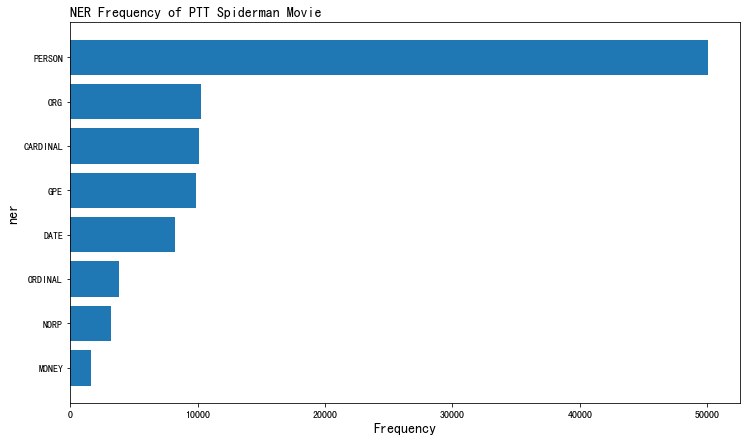

In [21]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Spiderman Movie',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 標記出的 Entity 是 PERSON 人物, ORG 組織 和 CARDINAL數字

### 涉及到的人名(PERSON)

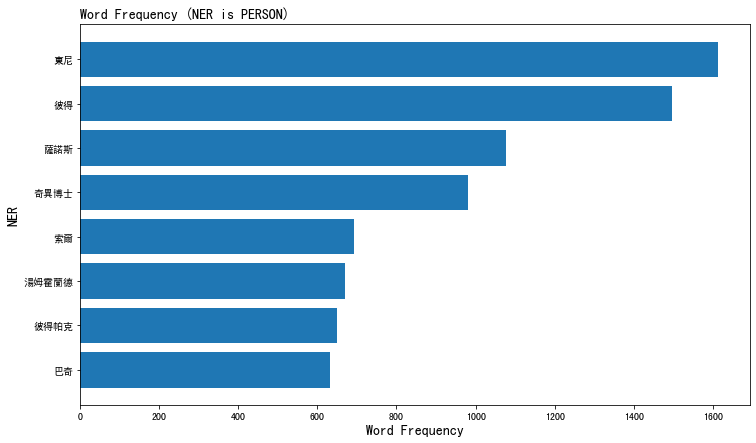

In [22]:
# 篩選ner為名詞的資料
l_noun = ["PERSON"]
PERSON = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前8個
ner_count = PERSON.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(8).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 抓出的人物也都是漫威的角色, 彼得和東尼出現的次數相近, 也是因為在 漫威電影宇宙中他們的關係非常親近。

### 涉及到的組織(ORG)

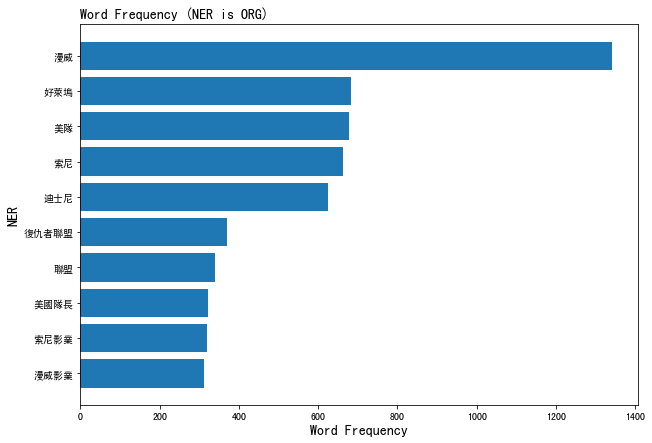

In [23]:
# 篩選ner為名詞的資料
l_noun = ["ORG"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORG)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 抓出的組織有漫威、迪士尼、索尼
### 以及最下面索尼影業和漫威影業等, 是因為蜘蛛人電影的版權原本是索尼的,後來被漫威影業買回去。

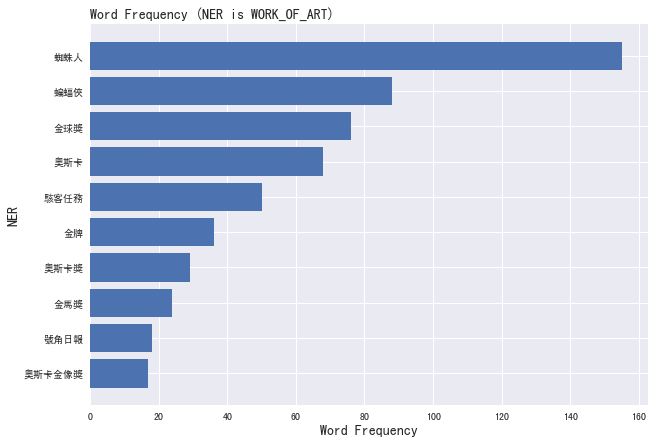

In [41]:
# 篩選ner為名詞的資料
l_noun = ["WORK_OF_ART"]
ORG = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = ORG.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is WORK_OF_ART)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 金球獎的出現次數蠻多的, 稍微查了一下, 發現是飾演第二代蜘蛛人的安德魯加菲爾在 《倒數時刻》的獎, 因此討論度比較高。
### 但比較特別的是蝙蝠俠的出現次數也蠻多的, 可能是很多人拿蜘蛛人和蝙蝠俠比較? 或者大眾給予影評的時候有同時討論到蜘蛛人以及蝙蝠俠。

In [48]:
keyword_list = ['蜘蛛人']
spiderman_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{spiderman_selected.shape[0]}篇相關貼文")
spiderman_selected.head(3)

蜘蛛人：4987篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/movie/M.1451797634.A.DC...,[好雷]2015回顧認真不負責年度十大電影,2016-01-03 05:01:11,allshine,movie,完整圖文版\nhttp://goo.gl/EyI1IU\n2015號稱強片年，好萊塢的大片一...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Yueshei"", ""c...",61.228.235.104,2018-04-27 17:58:04,ptt
1,2,https://www.ptt.cc/bbs/movie/M.1451920198.A.8B...,"Fw:[票房]2014年票房,imdb,爛蕃茄",2016-01-04 15:03:57,ooic,movie,整理了一下2014年一整年的電影票房 IMDB 爛蕃茄\n被列入的條件是北美週末票房有前幾名...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""yu1164"", ""cm...",None,2018-04-27 17:58:04,ptt
2,3,https://www.ptt.cc/bbs/movie/M.1451973067.A.35...,[新聞]「美國隊長3」新蜘蛛人超搶戲,2016-01-05 05:45:04,pili,movie,新聞網址：\nhttp://udn.com/news/story/7262/1420261\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""l8PeakNeymar...",61.230.19.241,2018-04-27 17:58:04,ptt


### 3 探索分析 - POS

In [ ]:
keyword_list = ['金球獎']
golden_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{golden_selected.shape[0]}篇相關貼文")
golden_selected.head(3)

### 3.3 探索分析 - POS

#### POS 種類分析
查看辨識出哪幾種POS<br>
名詞對應: https://ckip.iis.sinica.edu.tw/service/corenlp/ （左上角的標記列表）

In [ ]:
pos_table['pos'].unique()

看看除了標點符號，大部分的POS都是哪一類

In [52]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

,pos,count
18,Na,408148
5,D,214761
46,VH,125069
40,VC,117771
7,DE,116295
32,P,78856
19,Nb,71255
30,Nh,63135
28,Nf,52640
4,Cbb,48698


In [ ]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

#### POS 常見詞性列表
+ 中研院列表: https://ckip.iis.sinica.edu.tw/service/corenlp/
    + Na: 普通名詞
    + D: 副詞
    + VC: 動作及物動詞
    + Nb: 專有名詞
    + FW: 外文
    + VH: 狀態不及物動詞
    + Nh: 代名詞
    + DE: 的之得地
    + P: 介詞
    + VA: 動作不及物動詞
    + T: 語助詞
    + SHI: 是

### 涉及到的名詞(Noun)

In [ ]:
# 篩選pos為名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

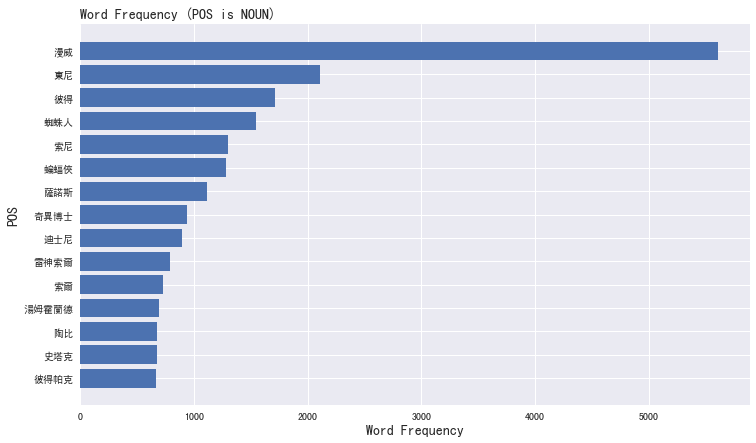

In [57]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 可以看到出現最多的名詞是漫威, 這是可以預期的, 再來就是蜘蛛人的導師東尼。我們也看到奇異博士、陶比等, 其中奇異博士是蜘蛛人:無家日的一名角色, 而陶比應該是因為他以第一代蜘蛛人的身分回歸, 才有討論度

### 涉及到的動詞(VERB)

In [141]:
l_verb = ["VH"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

,word,count
7031,這樣,2253
903,出現,2134
6662,超人,1757
5165,直接,1105
7380,防雷,1091
109,不同,985
3131,成功,933
7246,重要,917
289,不錯,766
4782,特別,738


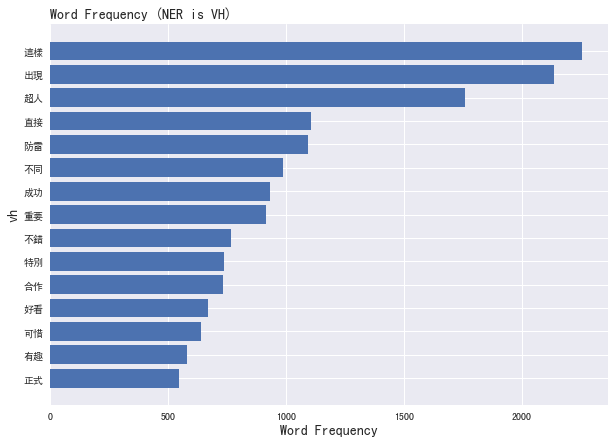

In [143]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is VH)',loc ='left', size = 14)
ax.set_ylabel('vh', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 可以看到裡面有出現 “成功”、“重要”、“不錯”、“特別”、“好看”、“有趣” 等正向的詞, 而 “可惜”這類負面的詞比較少, 可見大家對於蜘蛛人電影的評價還算是好的, 也可以看看之後情緒分析是否和這裡看到的一樣。

## 4. 利用SnowNLP進行情緒分析

+ SnowNLP 針對中文設計，可以提取句子的情緒分類
+ 使用文件分類法，套件已預先用文集訓練模型以判斷情緒
+ 情緒值在 0~1之間，代表負面到正面
+ 官方github: https://github.com/isnowfy/snownlp

In [60]:
from snownlp import SnowNLP

In [61]:
sentence_table = pd.read_csv("raw_data/sentence_spiderman.csv") #匯資料

sentiment_date = pd.merge(sentence_table,spiderman_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head()

,system_id,sentence,artDate,dataSource
0,1,完整圖文版,2016-01-03 05:01:11,ptt
1,1,///,2016-01-03 05:01:11,ptt
2,1,號稱強片年，好萊塢的大片波接波，票房紀錄個個破，但品質卻不見得個,2016-01-03 05:01:11,ptt
3,1,比個好,2016-01-03 05:01:11,ptt
4,1,尤其續集電影們雖然吊足了大家的胃口，但劇情的了無新意和預料中的發展，,2016-01-03 05:01:11,ptt


In [62]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head()

,system_id,sentence,artDate,dataSource,sentimentValue
0,1,完整圖文版,2016-01-03 05:01:11,ptt,0.521613
1,1,///,2016-01-03 05:01:11,ptt,0.250000
2,1,號稱強片年，好萊塢的大片波接波，票房紀錄個個破，但品質卻不見得個,2016-01-03 05:01:11,ptt,0.178945
3,1,比個好,2016-01-03 05:01:11,ptt,0.255488
4,1,尤其續集電影們雖然吊足了大家的胃口，但劇情的了無新意和預料中的發展，,2016-01-03 05:01:11,ptt,0.925511


In [63]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    190708.000000
mean          0.509944
std           0.341780
min           0.000000
25%           0.194906
50%           0.500000
75%           0.849959
max           1.000000
Name: sentimentValue, dtype: float64

<AxesSubplot:>

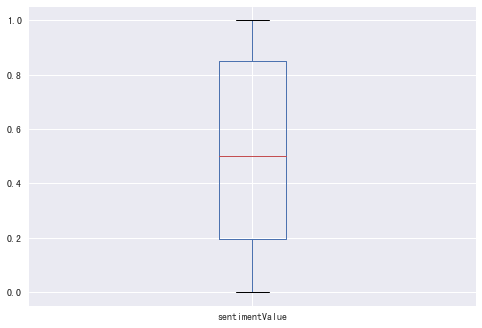

In [64]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

### 看boxplot 跟 describe , 可以看出sentimentValue 的平均高於0.5, 大家對於漫威電影宇宙的蜘蛛人的討論偏正向。也符合剛剛POS 分析所觀察出的結果。

將每個月的情緒分數取平均，並轉換時間格式為年月

In [65]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

,artDate,sentimentValue
0,2016-01,0.524259
1,2016-02,0.475123
2,2016-03,0.487468
3,2016-04,0.472800
4,2016-05,0.468584
...,...,...
83,2022-12,0.487779
84,2023-01,0.534922
85,2023-02,0.491325
86,2023-03,0.447022


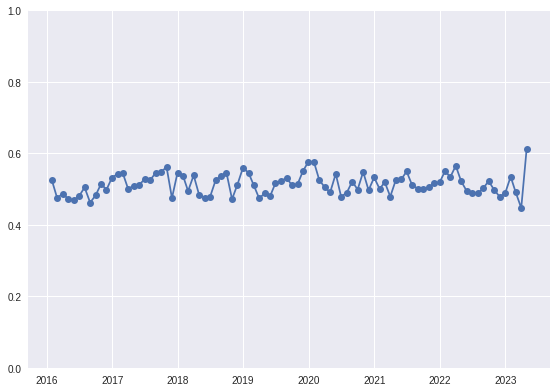

In [66]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

months = sentiment_count['artDate']
y = sentiment_count['sentimentValue']

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()
plt.ylim(0,1)

plt.show()

### 可以看到 2017年有一個上升的趨勢, 當時是漫威電影宇宙第一部蜘蛛人獨立電影釋出的時候, 可見大家非常期待這部電影。
### 在2023年 04月 有看到突然升起的趨勢, 也是最高峰

### 詞彙探索
我們從2023年04月看, 是為什麼會突然有那麼正面的討論度。

In [154]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2023-04']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.7]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
195969,5406,啟發自真實事件,2023-04,ptt,0.815295
195971,5406,傑克葛倫霍,2023-04,ptt,0.977118
195972,5406,耗資億打造最新戰爭動作鉅獻,2023-04,ptt,0.732659
195973,5406,絕地營救,2023-04,ptt,0.843838
195976,5406,年月，美軍全面撤軍阿富汗,2023-04,ptt,0.975582


In [155]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,5406,0.815295,///
1,5406,0.815295,啟發
2,5406,0.815295,自
3,5406,0.815295,真實
4,5406,0.815295,事件


In [156]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

In [157]:
# 自定停用字
with open('dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', 

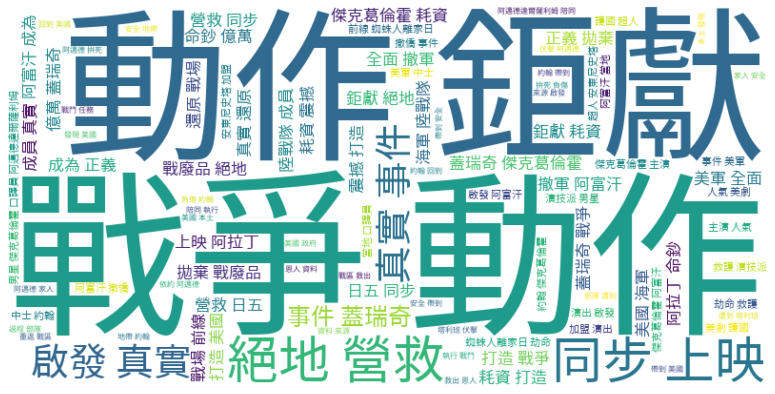

In [158]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('時間','營業','餐廳','覺得','排名','電影','全球','票房','盈利'
                       ,'合計','億','防雷','分隔線','雷文','主文','雷文主文'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

In [165]:
filter_sentiment.sort_values(by='sentimentValue', ascending=False)

,system_id,sentence,artDate,dataSource,sentimentValue
196002,5406,約翰回到美國本土後，發現美國政府沒有依約將阿邁德和他的家人安全帶到美國，於是決,2023-04,ptt,0.999914
195988,5406,劫命救護,2023-04,ptt,0.977670
195998,5406,傑克葛倫霍,2023-04,ptt,0.977118
195971,5406,傑克葛倫霍,2023-04,ptt,0.977118
195990,5406,傑克葛倫霍,2023-04,ptt,0.977118
195976,5406,年月，美軍全面撤軍阿富汗,2023-04,ptt,0.975582
195985,5406,耗資億震撼打造，,2023-04,ptt,0.970216
195993,5406,護國超人,2023-04,ptt,0.879443
195973,5406,絕地營救,2023-04,ptt,0.843838
195978,5406,絕地營救,2023-04,ptt,0.843838


In [172]:
pd.set_option('display.max_colwidth', None)
df[df['system_id']==5406]['artContent']

5405    https://i.imgur.com/YTb9CCm.jpg\n啟發自真實事件！\n蓋瑞奇\nX\n傑克葛倫霍\n耗資20億打造最新戰爭動作鉅獻《\n絕地營救\n》\n\nThe Covenant 4/21(五) 與全美同步上映\nhttps://youtu.be/PeG3rCoc_X8\n2021年8月，美軍全面撤軍阿富汗\n他，成為被正義之師拋棄的戰廢品……\n\n\n《\n絕地營救\n》4月21日(五) 與全美同步上映\n\n《\n阿拉丁\n》《\n玩命鈔劫\n》億萬大導\n蓋瑞奇\n最新戰爭動作鉅獻\n\n耗資20億震撼打造，\n\n前美國海軍陸戰隊成員真實還原戰場前線\n\n《\n蜘蛛人：離家日\n》《\n劫命救護\n》\n\n演技派男星\n傑克葛倫霍\n主演\n\n人氣美劇《\n》「護國超人」\n安東尼史塔\n加盟演出\n\n啟發自2021年阿富汗撤僑事件\n\n\n美軍中士約翰（\n傑克葛倫霍\n飾）在阿富汗當地的口譯員阿邁德（達爾薩利姆 飾）陪同下\n，執行戰鬥任務。\n\n然而在過程中，兩人的部隊遭到塔利班伏擊，阿邁德拚死將負傷的約翰帶到安全地帶。\n\n約翰回到美國本土後，發現美國政府沒有依約將阿邁德和他的家人安全帶到美國，於是決\n定重返戰區救出他的恩人……。\n\n#\n#GaragePlay\n資料來源：
Name: artContent, dtype: object

### 發現其實是蜘蛛人:離家日的其中一位演員 傑克葛倫德 有演出新的電影《絕地營救》, 裡面有提到他在蜘蛛人的演出, 因此才把蜘蛛人的討論度拉高。

#### 那我們還是以電影釋出的月份, 來看看大家的評價。我們看看蜘蛛人最新的電影 《蜘蛛人:無家日》

In [71]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2021-12']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.7]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
150399,4055,傳湯姆霍蘭德再演集蜘蛛人,2021-12,ptt,0.959478
150400,4055,葛大維,2021-12,ptt,0.821625
150401,4055,小蜘蛛還沒要畢業,2021-12,ptt,0.940238
150404,4055,蜘蛛人系列電影，至少三部,2021-12,ptt,0.984785
150405,4055,艾咪帕斯卡說無家日不是我們電影和漫威合作最後部電影，更不是,2021-12,ptt,0.871882


In [72]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,4055,0.959478,製片
1,4055,0.959478,說
2,4055,0.959478,了
3,4055,0.959478,算
4,4055,0.959478,傳


In [73]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲 《蜘蛛人:無家日》

In [74]:
# 自定停用字
with open('dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', 

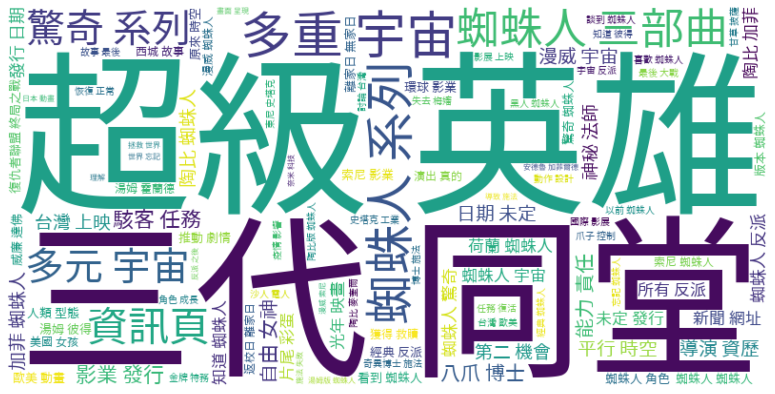

In [80]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('時間','營業','餐廳','覺得','排名','電影','全球','票房','盈利'
                       ,'合計','億','防雷','分隔線','雷文','主文','雷文主文'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

### 可以看到 三代同堂這個詞, 也是大家對於蜘蛛人:無家日最期待的事情, 裡面集結大家的童年第一代蜘蛛人, 以及第二代蜘蛛人, 三代蜘蛛人同時出演, 非常精彩, 也為漫威電影宇宙開啟多重宇宙的設定。 

負面分析

In [213]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2021-12']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.3]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
150403,4055,日製片之艾咪帕斯卡接受售票網站訪問，自爆將和湯姆霍蘭德繼續合作,2021-12,ptt,0.003027
150411,4055,蛛人離家日大賣座下，雙方同意再簽約合作部片蜘蛛人無家日,2021-12,ptt,0.144318
150427,4055,第場活動獎勵歐洲足球冠軍明星的金氣球節，影視媒體報導，湯,2021-12,ptt,0.104587
150431,4055,男湯姆霍蘭德則雙手插褲口袋派輕鬆，可能收到風聲，沒被拍到合體照,2021-12,ptt,0.002259
150433,4055,雜誌訪問被問到感情狀況說我非常尊重她，但那不是我個人的事，而是我們兩人,2021-12,ptt,0.033922


In [214]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,4055,0.003027,製片
1,4055,0.003027,說
2,4055,0.003027,了
3,4055,0.003027,算
4,4055,0.003027,傳


In [217]:
neg_words.sort_values(by="sentimentValue",ascending=True)

,system_id,sentimentValue,word
710594,4125,1.095220e-08,在場
710687,4125,1.095220e-08,小心
710690,4125,1.095220e-08,跑來
710693,4125,1.095220e-08,世界
710695,4125,1.095220e-08,陶比
...,...,...,...
1860824,4334,2.998013e-01,漫畫
1860828,4334,2.998013e-01,角色
1860830,4334,2.998013e-01,哨兵
1860797,4334,2.998013e-01,肉體


In [216]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 負面詞彙文字雲 蜘蛛人:無家日

In [210]:
# 自定停用字
with open('dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', 

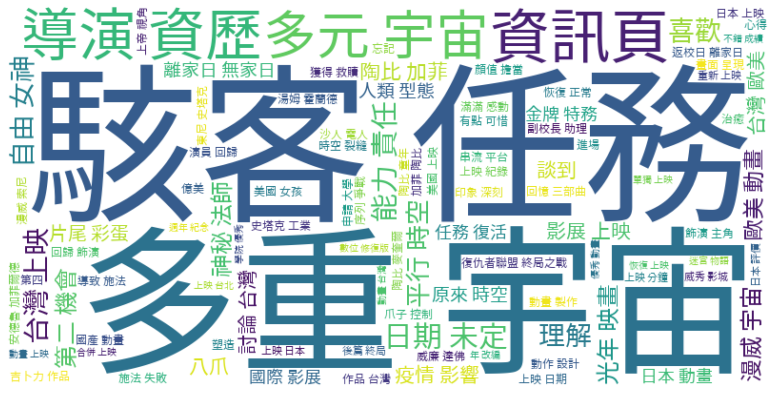

In [225]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('時間','營業','餐廳','覺得','排名','電影','全球','票房','盈利'
                       ,'合計','億','防雷','分隔線','雷文','主文','雷文主文','蜘蛛人'
                       ,'說','人','綠','惡魔','綠惡魔','只','知道','反派',"突然","想到","無法","近期","看到","想起","一部片","回憶起","這部",
                    "最後","知道","希望","發現","分隔線","現在","變成","這種","電影",
                    "網址","看過","選擇","更多","能夠","能夠","今天","太多","期待",
                    "整個","一部","觀眾","發生","直接","看完","以下","今年","這部片","至少"
                   "一點","感覺","一直","好像","兩個","NT90","兩個","表示","那種","之後","一下","根本","10","以前","尤其","當年","完全"
                       ,"次","部","真的","全台","段","奇異博士","全","台","想","代","好","角色","荷蘭","片","出現","集","世界","兩","點"
                       ,"位","三代","同堂","超級","英雄","影業","發行","",""))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

## 接下來看看《蜘蛛人:離家日》的電影情緒分數

In [192]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2019-07']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.7]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
107668,2664,蜘蛛人返校日,2019-07,ptt,0.813314
107674,2665,今天和大家分享蜘蛛人鋼琴組曲,2019-07,ptt,0.998276
107691,2666,想法，但他仍然非常尊敬史丹李老爺爺，也希望透過這部電影來向這位漫威之父致意,2019-07,ptt,0.885168
107695,2667,漫威宇宙無限傳說最終章蜘蛛人離家日將在本週三月日起週二深夜,2019-07,ptt,0.849410
107697,2667,本次於暑期的強勢回歸適逢台灣大學指考，除了有影史最棒蜘,2019-07,ptt,0.998161


In [193]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,2664,0.813314,蜘蛛人返校日
1,2664,0.813314,///
2,2664,0.813314,應該
3,2664,0.813314,是
4,2664,0.813314,第二


In [194]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲 《蜘蛛人:離家日》

In [195]:
# 自定停用字
with open('dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', 

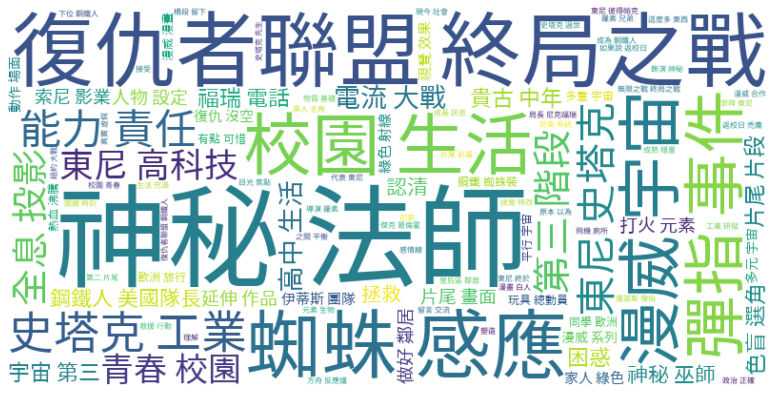

In [ ]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('時間','營業','餐廳','覺得','排名','電影','全球','票房','盈利'
                       ,'合計','億','防雷','分隔線','雷文','主文','雷文主文','蜘蛛人'
                       ,'說','人','綠','惡魔','綠惡魔','只','知道','反派',"突然","想到","無法","近期","看到","想起","一部片","回憶起","這部",
                    "最後","知道","希望","發現","分隔線","現在","變成","這種","電影",
                    "網址","看過","選擇","更多","能夠","能夠","今天","太多","期待",
                    "整個","一部","觀眾","發生","直接","看完","以下","今年","這部片","至少"
                   "一點","感覺","一直","好像","兩個","NT90","兩個","表示","那種","之後","一下","根本","10","以前","尤其","當年","完全"
                       ,"次","部","真的","全台","段","奇異博士","全","台","想","代","好","角色","荷蘭","片","出現","集","世界","兩","點"
                       ,"位","彼得","梅嬸","驚奇","應該","部分","劇情","蛛","萬","爪","博士","整","超級英雄","超級","英雄","資訊頁","","","","","",""))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

### 可以看到裡面出現了神秘法師的詞眼, 這是前面的分析提到的傑克葛倫德所演出的角色
### 可以看出大家在討論蜘蛛人的時候, 都是在討論裡面的劇情, 比較少是在給予評價, 或許應該把這些詞眼當成停用字, 才能看到對電影的評價。

### 最後再看看 《蜘蛛人:返家日》 的文章情緒

In [129]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2017-07']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.7]

filter_sentiment.head()

,system_id,sentence,artDate,dataSource,sentimentValue
36799,835,長久以來，漫威直將旗下的超級英雄加入到自己的電影宇宙當中，但還是有很多超級英雄,2017-07,ptt,1.000000
36801,835,你沒看錯，不是美國隊長，而是被,2017-07,ptt,0.960660
36803,835,如果漫威需要在第四階段納入更多超級英雄，那英國隊長無,2017-07,ptt,0.982221
36805,835,近日有外媒在採訪蜘蛛俠英雄歸來的製片人艾米·帕斯卡爾與漫威總裁凱文·費奇時,2017-07,ptt,0.957548
36811,835,英國隊長也是漫威旗下的超級英雄，在年的漫畫英國隊長中首次登場,2017-07,ptt,0.992953


In [130]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,835,1.0,長久以來
1,835,1.0,，
2,835,1.0,漫威
3,835,1.0,直
4,835,1.0,將


In [131]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲 《蜘蛛人:返家日》

In [132]:
# 自定停用字
with open('dict/stop_words.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', 

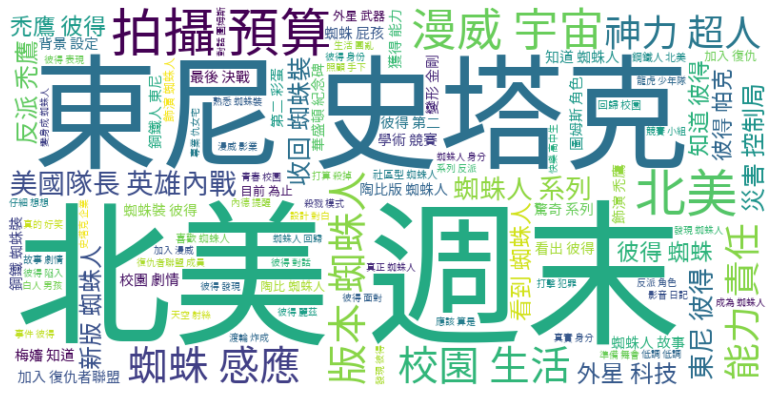

In [134]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('時間','營業','餐廳','覺得','排名','電影','全球','票房','盈利'
                       ,'合計','億','防雷','分隔線','雷文','主文','雷文主文','超級','英雄'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

# 最後看看一下今年漫威電影大家的評價

In [226]:
# 篩時間區間
filter_sentiment = sent_date[sent_date['artDate'].between('2023-01','2023-04')]
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.375]

# 看一下負面句子都在討論甚麼
filter_sentiment[5:15]

,system_id,sentence,artDate,dataSource,sentimentValue
192254,5325,黑豹瓦干達萬歲/華特迪士尼工作室電影/億萬,2023-01,ptt,0.221797
192257,5326,捍衛戰士獨行俠萬人,2023-01,ptt,0.137026
192268,5326,黑豹瓦干達萬歲萬人,2023-01,ptt,0.096835
192271,5326,樂透大作戰萬人,2023-01,ptt,0.309837
192277,5327,台灣年月日上映,2023-01,ptt,0.199708
192279,5327,無雷心得,2023-01,ptt,0.217695
192282,5327,已經很久沒聽到這樣的感覺,2023-01,ptt,0.002482
192285,5327,劇情不拖片長分鐘,2023-01,ptt,0.273775
192286,5327,冒險與廢話的感覺不會太多,2023-01,ptt,0.000932
192288,5327,然後我只想說,2023-01,ptt,0.317762


In [227]:
# 把時間分數和之前斷詞的token table做 join
neg_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
neg_words = neg_words[['system_id','sentimentValue','word']]
neg_words.head()

,system_id,sentimentValue,word
0,5325,0.230785,航海王
1,5325,0.230785,劇場版
2,5325,0.230785,紅髮
3,5325,0.230785,歌姬
4,5325,0.230785,/


In [228]:
# 篩選掉只有單個字元的結果
neg_words = neg_words[neg_words.apply(lambda x: len(x['word'])>1, axis=1)]

In [230]:
# 自定停用字
with open('dict/stop_words.txt',encoding='UTF-8') as f:
    stop_words = f.read().splitlines()

print(stop_words)

[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '可否', '有無', '再', '本來', '是不是', '一個', '這種', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', 

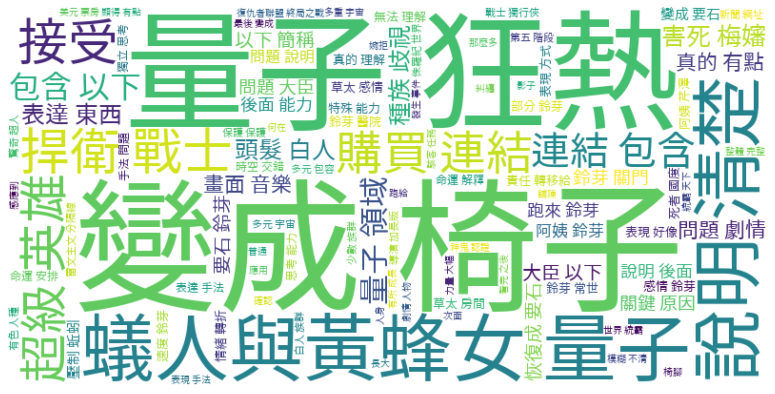

In [234]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('時間','營業','餐廳','覺得','公路','電影','恢復','原狀','開放式','教育'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,font_path=font_path,width=800, height = 400, max_words=100, background_color="white")

wordcloud.generate(' '.join(neg_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

### 結論
在做超級英雄電影相關的分析時, 很長會出現 “英雄” “超級” “復仇” 等詞, 這會影響到文章的情緒分數, 使算出的情緒分數可能不準確。
此外, 有些人會同時討論多個電影, 或提及某個演員曾今演出某個電影, 導致在分析的時候, 所取得的文章可能與想要討論的電影無關, 或受其它電影的評價影響要討論的電影的情緒分數。